In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def visualize_gmm_results(param_file, result_file, data_file=None):
    """
    Visualize GMM clustering results with model parameters.
    
    Parameters:
    - param_file: CSV file containing GMM parameters (component weights, means, covariances)
    - result_file: CSV file containing clustering results
    - data_file: Optional CSV file containing original data points. If None, will use the indices from results.
    
    Returns:
    - None (displays plots)
    """
    # Load model parameters
    params_df = pd.read_csv(param_file)
    
    # Load clustering results
    results_df = pd.read_csv(result_file)
    
    # Load or generate data points
    if data_file:
        data_df = pd.read_csv(data_file)
        X = data_df[['x', 'y']].values
    else:
        # If no data provided, use indices as x-coordinates and create dummy y-coordinates
        # This is just for visualization when actual data isn't available
        X = np.column_stack((results_df['index'].values, np.zeros(len(results_df))))
    
    # Get cluster assignments
    y_pred = results_df['predicted_cluster'].values
    
    # Extract model parameters
    weights = []
    means = []
    covariances = []
    
    for _, row in params_df.iterrows():
        weights.append(row['Weight'])
        
        # Parse mean vector (assumes format "x y")
        mean_str = row['Mean']
        mean_vals = [float(val) for val in mean_str.split()]
        means.append(mean_vals)
        
        # Parse covariance matrix (assumes format "a b c d" for 2x2 matrix)
        cov_str = row['Covariance']
        cov_vals = [float(val) for val in cov_str.split()]
        cov_matrix = np.array([
            [cov_vals[0], cov_vals[1]],
            [cov_vals[2], cov_vals[3]]
        ])
        covariances.append(cov_matrix)
    
    # Convert to numpy arrays
    means = np.array(means)
    
    # Create figure
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Original data with cluster assignments
    plt.subplot(2, 2, 1)
    unique_clusters = np.unique(y_pred)
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters)))
    
    for i, cluster in enumerate(unique_clusters):
        mask = y_pred == cluster
        plt.scatter(X[mask, 0], X[mask, 1], color=colors[i], alpha=0.7, label=f'Cluster {cluster}')
    
    plt.title('GMM Clustering Results')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    
    # Plot 2: Cluster centers with confidence ellipses
    plt.subplot(2, 2, 2)
    
    # Function to draw confidence ellipse for each cluster
    def draw_ellipse(position, covariance, ax=None, **kwargs):
        """Draw an ellipse based on a covariance matrix."""
        ax = ax or plt.gca()
        
        # Convert covariance to principal axes
        if covariance.shape == (2, 2):
            U, s, Vt = np.linalg.svd(covariance)
            angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
            width, height = 2 * np.sqrt(s)
        else:
            angle = 0
            width, height = 2 * np.sqrt(covariance)
        
        # Draw the Ellipse
        for nsig in [1, 2, 3]:
            ax.add_patch(Ellipse(position, width=nsig*width, height=nsig*height,
                                  angle=angle, **kwargs))
    
    # Plot data points with transparency
    plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='viridis', alpha=0.3)
    
    # Plot ellipses for each component
    for i, (weight, mean, cov) in enumerate(zip(weights, means, covariances)):
        color = colors[i % len(colors)]
        draw_ellipse(mean, cov, alpha=0.3, color=color)
        plt.scatter(mean[0], mean[1], s=200, color=color, marker='x', linewidth=2)
        plt.annotate(f'Component {i}\nWeight: {weight:.2f}', 
                     xy=(mean[0], mean[1]),
                     xytext=(10, 10),
                     textcoords='offset points',
                     fontsize=10,
                     bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.3))
    
    plt.title('GMM Components with Confidence Ellipses')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    
    # Plot 3: Cluster distribution
    plt.subplot(2, 2, 3)
    cluster_counts = pd.Series(y_pred).value_counts().sort_index()
    cluster_counts.plot(kind='bar', color=colors[:len(cluster_counts)])
    plt.title('Cluster Size Distribution')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Samples')
    
    # Plot 4: Component weights
    plt.subplot(2, 2, 4)
    component_indices = np.arange(len(weights))
    plt.bar(component_indices, weights, color=colors[:len(weights)])
    plt.title('GMM Component Weights')
    plt.xlabel('Component')
    plt.ylabel('Weight')
    plt.xticks(component_indices)
    
    plt.tight_layout()
    plt.show()

    # Additional information
    print("\nGMM Model Parameters:")
    for i, (weight, mean, cov) in enumerate(zip(weights, means, covariances)):
        print(f"Component {i}:")
        print(f"  Weight: {weight:.4f}")
        print(f"  Mean: [{mean[0]:.4f}, {mean[1]:.4f}]")
        print(f"  Covariance Matrix:")
        print(f"    [{cov[0,0]:.4f}, {cov[0,1]:.4f}]")
        print(f"    [{cov[1,0]:.4f}, {cov[1,1]:.4f}]")
        print()

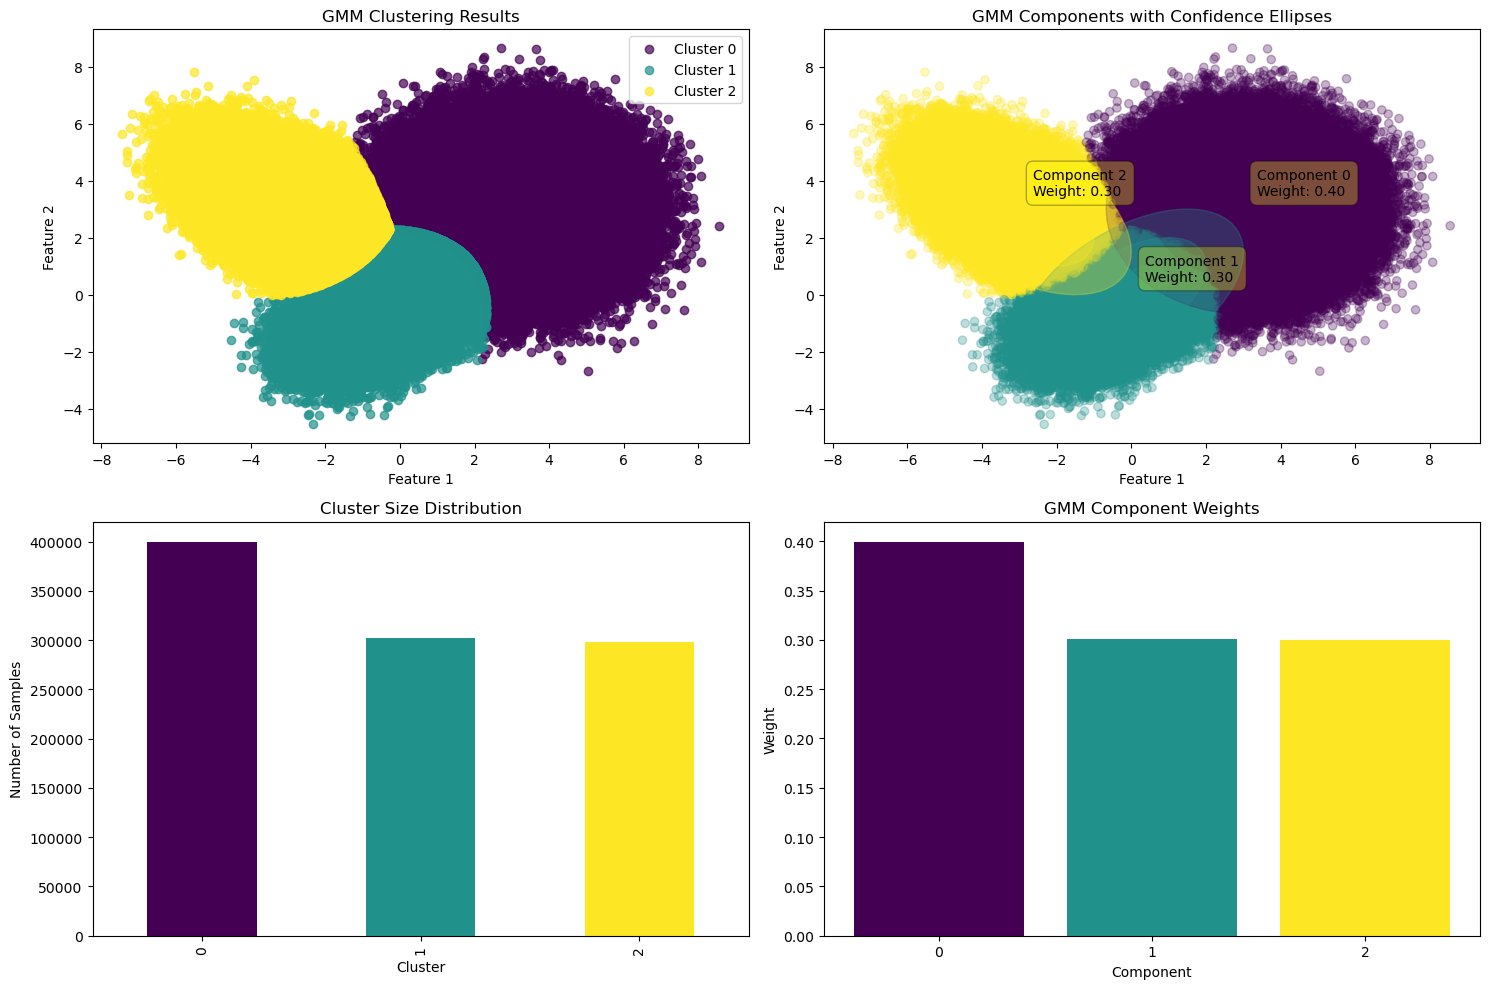


GMM Model Parameters:
Component 0:
  Weight: 0.3997
  Mean: [2.9976, 3.0008]
  Covariance Matrix:
    [1.4977, -0.0053]
    [-0.0053, 1.5032]

Component 1:
  Weight: 0.3004
  Mean: [0.0029, 0.0001]
  Covariance Matrix:
    [1.0000, 0.5006]
    [0.5006, 1.0039]

Component 2:
  Weight: 0.3000
  Mean: [-2.9999, 3.0013]
  Covariance Matrix:
    [0.9986, -0.4980]
    [-0.4980, 1.0007]



In [3]:
# Assuming you have your files available
param_file = "gmm_parameters_python.csv"
result_file = "gmm_results_python.csv"

# If you have the original data points (optional)
data_file = "datasets/gmm_data.csv"  

# Call the function
visualize_gmm_results(param_file, result_file, data_file)

# Or without data file (will use indices as x-coordinates)
# visualize_gmm_results(param_file, result_file)

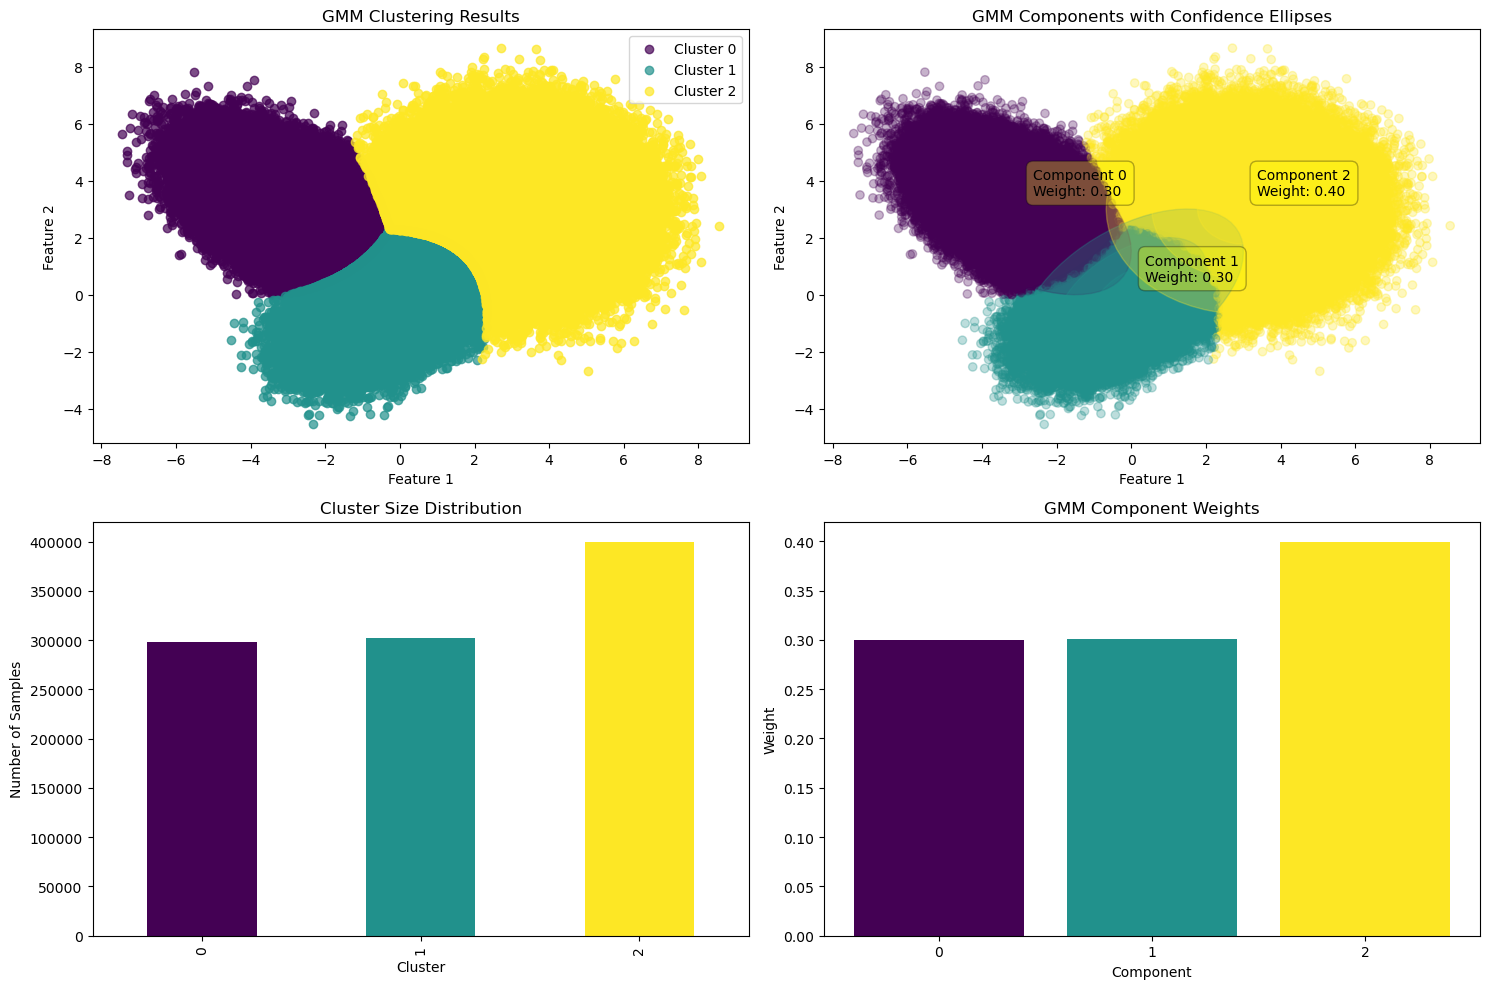


GMM Model Parameters:
Component 0:
  Weight: 0.3000
  Mean: [-2.9998, 3.0013]
  Covariance Matrix:
    [0.9986, -0.4980]
    [-0.4980, 1.0007]

Component 1:
  Weight: 0.3004
  Mean: [0.0029, 0.0001]
  Covariance Matrix:
    [1.0000, 0.5006]
    [0.5006, 1.0039]

Component 2:
  Weight: 0.3997
  Mean: [2.9976, 3.0008]
  Covariance Matrix:
    [1.4977, -0.0053]
    [-0.0053, 1.5032]



In [12]:
# Visualizing CPP Results

param_file_cpp = "gmm_model_parameters_cpp.csv"
result_file_cpp = "gmm_predictions_cpp.csv"

# If you have the original data points (optional)
data_file_cpp = "datasets/gmm_data.csv"

# Call the function for C++ results
visualize_gmm_results(param_file_cpp, result_file_cpp, data_file_cpp)

In [5]:
def compare_gmm_implementations(python_param_file, python_result_file, 
                               cpp_param_file, cpp_result_file, 
                               data_file=None):
    """
    Compare GMM clustering results between Python and C++ implementations.
    
    Parameters:
    - python_param_file: CSV file containing Python GMM parameters
    - python_result_file: CSV file containing Python clustering results
    - cpp_param_file: CSV file containing C++ GMM parameters
    - cpp_result_file: CSV file containing C++ clustering results
    - data_file: Optional CSV file containing original data points
    
    Returns:
    - None (displays comparison plots and metrics)
    """
    # Load model parameters
    py_params_df = pd.read_csv(python_param_file)
    cpp_params_df = pd.read_csv(cpp_param_file)
    
    # Load clustering results
    py_results_df = pd.read_csv(python_result_file)
    cpp_results_df = pd.read_csv(cpp_result_file)
    
    # Load data points
    if data_file:
        data_df = pd.read_csv(data_file)
        X = data_df[['x', 'y']].values
    else:
        # If no data provided, use indices as x-coordinates
        X = np.column_stack((py_results_df['index'].values, np.zeros(len(py_results_df))))
    
    # Get cluster assignments
    py_pred = py_results_df['predicted_cluster'].values
    cpp_pred = cpp_results_df['predicted_cluster'].values
    
    # Extract model parameters
    def extract_params(params_df):
        weights = []
        means = []
        covariances = []
        
        for _, row in params_df.iterrows():
            weights.append(float(row['Weight']))
            
            # Parse mean vector (assumes format "x y")
            mean_str = row['Mean']
            mean_vals = [float(val) for val in mean_str.split()]
            means.append(mean_vals)
            
            # Parse covariance matrix (assumes format "a b c d" for 2x2 matrix)
            cov_str = row['Covariance']
            cov_vals = [float(val) for val in cov_str.split()]
            cov_matrix = np.array([
                [cov_vals[0], cov_vals[1]],
                [cov_vals[2], cov_vals[3]]
            ])
            covariances.append(cov_matrix)
        
        return np.array(weights), np.array(means), covariances
    
    py_weights, py_means, py_covs = extract_params(py_params_df)
    cpp_weights, cpp_means, cpp_covs = extract_params(cpp_params_df)
    
    # Create visualization
    plt.figure(figsize=(15, 12))
    
    # Function to draw confidence ellipse for each cluster
    def draw_ellipse(position, covariance, ax=None, **kwargs):
        """Draw an ellipse based on a covariance matrix."""
        ax = ax or plt.gca()
        
        # Convert covariance to principal axes
        if covariance.shape == (2, 2):
            U, s, Vt = np.linalg.svd(covariance)
            angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
            width, height = 2 * np.sqrt(s)
        else:
            angle = 0
            width, height = 2 * np.sqrt(covariance)
        
        # Draw the Ellipse
        for nsig in [1, 2]:  # Draw 1 and 2 sigma ellipses
            ax.add_patch(Ellipse(position, width=nsig*width, height=nsig*height,
                                angle=angle, **kwargs))
    
    # Plot 1: Python Clustering Results
    ax1 = plt.subplot(2, 2, 1)
    plt.scatter(X[:, 0], X[:, 1], c=py_pred, cmap='viridis', alpha=0.5, s=10)
    
    # Plot Python model components
    for i, (weight, mean, cov) in enumerate(zip(py_weights, py_means, py_covs)):
        color = plt.cm.viridis(i/len(py_weights))
        draw_ellipse(mean, cov, ax=ax1, alpha=0.3, color=color, fill=False, linewidth=2)
        plt.scatter(mean[0], mean[1], s=100, color=color, marker='x', linewidth=2)
    
    plt.title('Python GMM Clustering')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    
    # Plot 2: C++ Clustering Results
    ax2 = plt.subplot(2, 2, 2)
    plt.scatter(X[:, 0], X[:, 1], c=cpp_pred, cmap='viridis', alpha=0.5, s=10)
    
    # Plot C++ model components
    for i, (weight, mean, cov) in enumerate(zip(cpp_weights, cpp_means, cpp_covs)):
        color = plt.cm.viridis(i/len(cpp_weights))
        draw_ellipse(mean, cov, ax=ax2, alpha=0.3, color=color, fill=False, linewidth=2)
        plt.scatter(mean[0], mean[1], s=100, color=color, marker='x', linewidth=2)
    
    plt.title('C++ GMM Clustering')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    
    # Plot 3: Clustering Agreement
    ax3 = plt.subplot(2, 2, 3)
    agreement = (py_pred == cpp_pred)
    plt.scatter(X[agreement, 0], X[agreement, 1], c='green', label='Agreement', alpha=0.5, s=10)
    plt.scatter(X[~agreement, 0], X[~agreement, 1], c='red', label='Disagreement', alpha=0.5, s=10)
    plt.title('Clustering Agreement Between Implementations')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    
    # Plot 4: Parameter Comparison
    ax4 = plt.subplot(2, 2, 4)
    
    # Compare weights
    width = 0.35
    indices = np.arange(len(py_weights))
    
    ax4.bar(indices - width/2, py_weights, width, label='Python Weights', alpha=0.7)
    ax4.bar(indices + width/2, cpp_weights, width, label='C++ Weights', alpha=0.7)
    
    ax4.set_xlabel('Component')
    ax4.set_ylabel('Weight')
    ax4.set_title('Weight Comparison')
    ax4.set_xticks(indices)
    ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Calculate comparison metrics
    agreement_percentage = np.mean(agreement) * 100
    
    # Calculate parameter differences
    mean_diffs = []
    cov_diffs = []
    weight_diffs = []
    
    # We need to match components between the two implementations
    # A simple but not perfect approach: match by closest means
    cpp_matched_indices = []
    for py_mean in py_means:
        distances = np.linalg.norm(cpp_means - py_mean, axis=1)
        closest = np.argmin(distances)
        cpp_matched_indices.append(closest)
    
    for i, cpp_idx in enumerate(cpp_matched_indices):
        mean_diff = np.linalg.norm(py_means[i] - cpp_means[cpp_idx])
        mean_diffs.append(mean_diff)
        
        # Frobenius norm for covariance difference
        cov_diff = np.linalg.norm(np.array(py_covs[i]) - np.array(cpp_covs[cpp_idx]))
        cov_diffs.append(cov_diff)
        
        weight_diff = abs(py_weights[i] - cpp_weights[cpp_idx])
        weight_diffs.append(weight_diff)
    
    # Print comparison metrics
    print("\n===== Python vs C++ GMM Implementation Comparison =====")
    print(f"Clustering Agreement: {agreement_percentage:.2f}%")
    print(f"Number of disagreements: {np.sum(~agreement)} out of {len(agreement)} points")
    print("\nParameter Differences (Python vs C++):")
    
    for i, cpp_idx in enumerate(cpp_matched_indices):
        print(f"\nComponent {i} (Python) <-> Component {cpp_idx} (C++):")
        print(f"  Mean Distance: {mean_diffs[i]:.4f}")
        print(f"  Covariance Difference: {cov_diffs[i]:.4f}")
        print(f"  Weight Difference: {weight_diffs[i]:.4f}")
        print(f"  Python Mean: {py_means[i]}")
        print(f"  C++ Mean: {cpp_means[cpp_idx]}")
        
    # Summary statistics
    print("\nSummary Statistics:")
    print(f"  Average Mean Distance: {np.mean(mean_diffs):.4f}")
    print(f"  Average Covariance Difference: {np.mean(cov_diffs):.4f}")
    print(f"  Average Weight Difference: {np.mean(weight_diffs):.4f}")

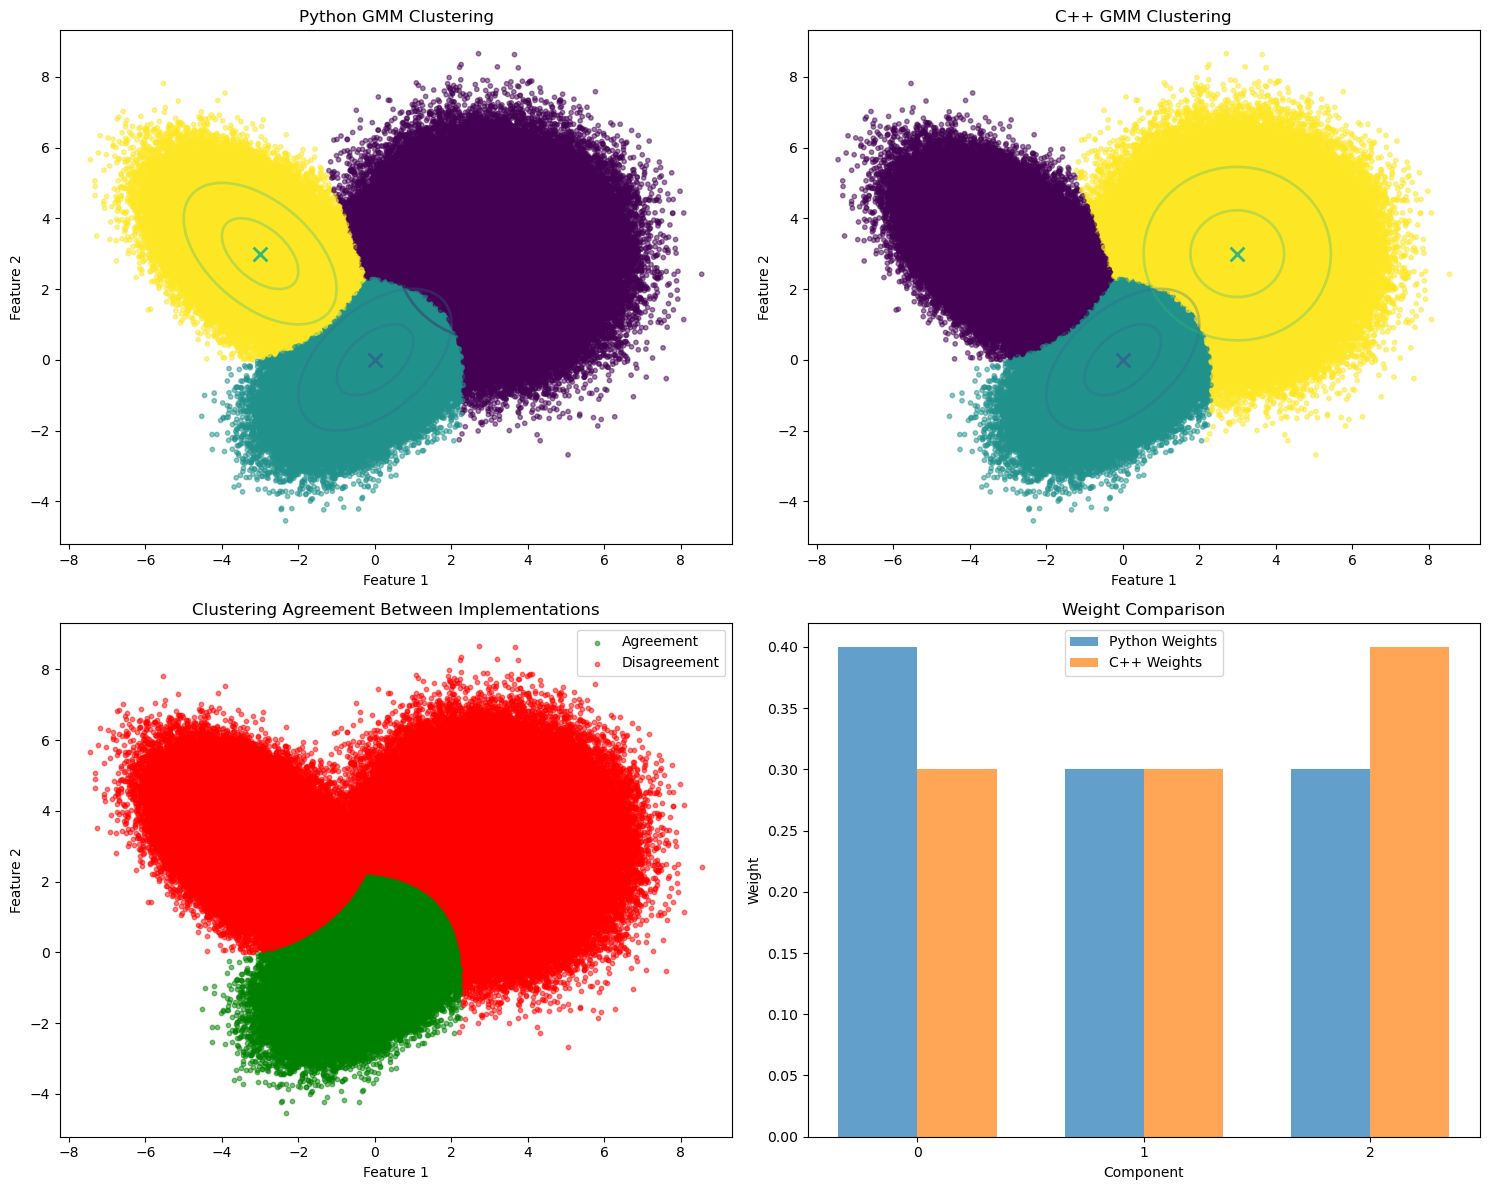


===== Python vs C++ GMM Implementation Comparison =====
Clustering Agreement: 30.18%
Number of disagreements: 698204 out of 1000000 points

Parameter Differences (Python vs C++):

Component 0 (Python) <-> Component 2 (C++):
  Mean Distance: 0.0000
  Covariance Difference: 0.0001
  Weight Difference: 0.0000
  Python Mean: [2.99760497 3.00078328]
  C++ Mean: [2.99758 3.00076]

Component 1 (Python) <-> Component 1 (C++):
  Mean Distance: 0.0000
  Covariance Difference: 0.0001
  Weight Difference: 0.0000
  Python Mean: [0.00289557 0.00012843]
  C++ Mean: [2.86618e-03 9.77355e-05]

Component 2 (Python) <-> Component 0 (C++):
  Mean Distance: 0.0000
  Covariance Difference: 0.0000
  Weight Difference: 0.0000
  Python Mean: [-2.99985259  3.00125871]
  C++ Mean: [-2.99985  3.00126]

Summary Statistics:
  Average Mean Distance: 0.0000
  Average Covariance Difference: 0.0000
  Average Weight Difference: 0.0000


In [9]:
# Example usage
compare_gmm_implementations(
    python_param_file="gmm_parameters_python.csv",
    python_result_file="gmm_results_python.csv",
    cpp_param_file="gmm_model_parameters_cpp.csv",
    cpp_result_file="gmm_predictions_cpp.csv",
    data_file="datasets/gmm_data.csv"
)

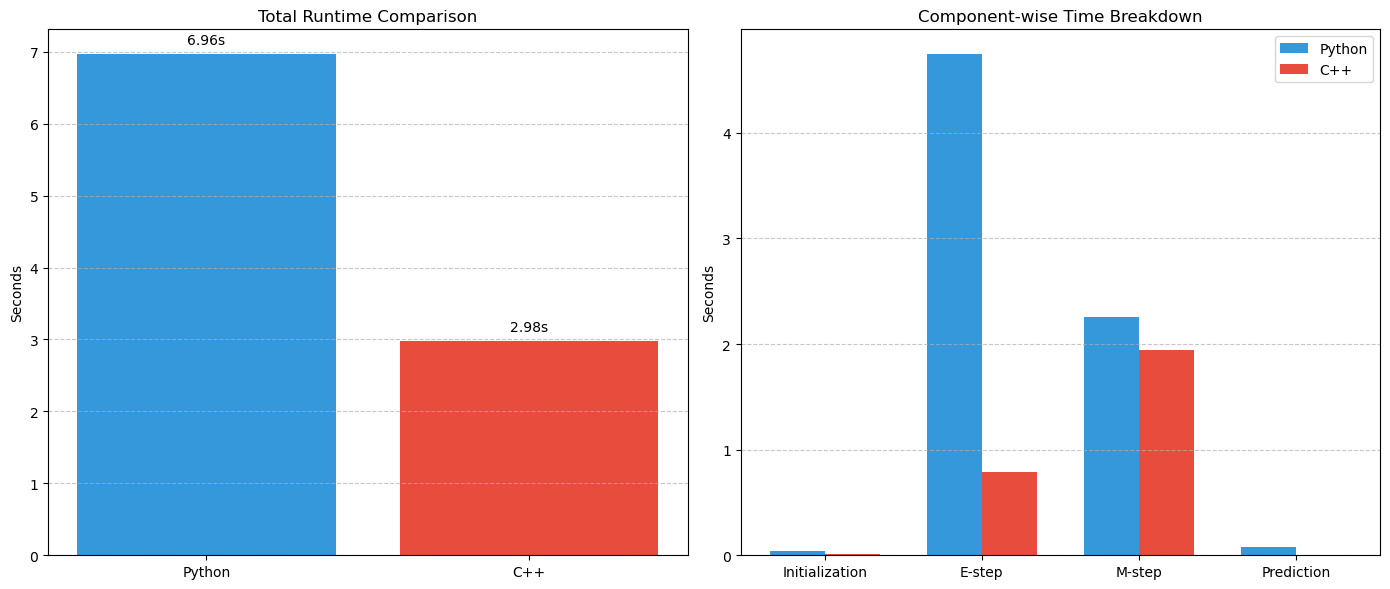

Comparison visualization saved to gmm_timing_comparison.png


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

def compare_gmm_timing(python_timing_file, cpp_timing_file, output_image='gmm_timing_comparison.png'):
    """
    Compare the timing information between Python and C++ GMM implementations.
    
    Parameters:
    -----------
    python_timing_file : str
        Path to the Python GMM timing summary file
    cpp_timing_file : str
        Path to the C++ GMM timing summary file
    output_image : str
        Path to save the comparison visualization
    """
    # Regular expressions to extract data
    runtime_pattern = r"Total runtime: (\d+\.\d+) seconds"
    iterations_pattern = r"Total iterations: (\d+)"
    avg_iter_pattern = r"Average iteration time: (\d+\.\d+) seconds"
    prediction_pattern = r"Prediction time: (\d+\.\d+) seconds"
    init_pattern = r"Initialization: (\d+\.\d+) seconds"
    estep_pattern = r"E-step total: (\d+\.\d+) seconds \((\d+\.\d+)%\)"
    mstep_pattern = r"M-step total: (\d+\.\d+) seconds \((\d+\.\d+)%\)"
    
    # Function to extract data from file
    def extract_data(file_path):
        with open(file_path, 'r') as f:
            content = f.read()
            
        data = {}
        
        # Extract implementation type
        if "Python" in content:
            data['implementation'] = "Python"
        else:
            data['implementation'] = "C++"
            
        # Extract basic metrics
        data['runtime'] = float(re.search(runtime_pattern, content).group(1))
        data['iterations'] = int(re.search(iterations_pattern, content).group(1))
        data['avg_iter_time'] = float(re.search(avg_iter_pattern, content).group(1))
        
        prediction_match = re.search(prediction_pattern, content)
        data['prediction_time'] = float(prediction_match.group(1)) if prediction_match else 0
        
        # Extract detailed metrics
        data['init_time'] = float(re.search(init_pattern, content).group(1))
        
        estep_match = re.search(estep_pattern, content)
        data['estep_time'] = float(estep_match.group(1))
        data['estep_percent'] = float(estep_match.group(2))
        
        mstep_match = re.search(mstep_pattern, content)
        data['mstep_time'] = float(mstep_match.group(1))
        data['mstep_percent'] = float(mstep_match.group(2))
        
        return data
    
    # Extract data from both files
    python_data = extract_data(python_timing_file)
    cpp_data = extract_data(cpp_timing_file)
    
    # Create the visualization with only 2 plots
    plt.figure(figsize=(14, 6))
    
    # 1. Overall Runtime Comparison
    plt.subplot(1, 2, 1)
    implementations = ['Python', 'C++']
    runtimes = [python_data['runtime'], cpp_data['runtime']]
    colors = ['#3498db', '#e74c3c']
    
    bars = plt.bar(implementations, runtimes, color=colors)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height:.2f}s', ha='center', va='bottom')
    
    plt.title('Total Runtime Comparison')
    plt.ylabel('Seconds')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 2. Component-wise Time Breakdown
    plt.subplot(1, 2, 2)
    components = ['Initialization', 'E-step', 'M-step', 'Prediction']
    python_times = [
        python_data['init_time'],
        python_data['estep_time'],
        python_data['mstep_time'],
        python_data['prediction_time']
    ]
    cpp_times = [
        cpp_data['init_time'],
        cpp_data['estep_time'],
        cpp_data['mstep_time'],
        cpp_data['prediction_time']
    ]
    
    x = np.arange(len(components))
    width = 0.35
    
    plt.bar(x - width/2, python_times, width, label='Python', color='#3498db')
    plt.bar(x + width/2, cpp_times, width, label='C++', color='#e74c3c')
    
    plt.title('Component-wise Time Breakdown')
    plt.xticks(x, components)
    plt.ylabel('Seconds')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Save plot
    plt.tight_layout()
    plt.savefig(output_image)
    plt.show()
    
    print(f"Comparison visualization saved to {output_image}")
    
    return python_data, cpp_data

# Example usage
if __name__ == "__main__":
    python_timing_file = "timing_results/python_gmm_timing_summary.txt"
    cpp_timing_file = "timing_results/cpp_gmm_timing_summary.txt"
    compare_gmm_timing(python_timing_file, cpp_timing_file)